In [2]:

import numpy as np
import librosa

In [3]:
song, Fs = librosa.load("train_audio.mp3", sr=44100)

//anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [4]:
len(song)

6727680

In [5]:
Fs

44100

In [6]:
import matplotlib.pyplot as plt

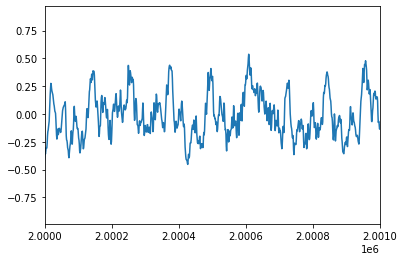

In [22]:
plt.xlim(2e6,2.001e6)
plt.plot(song)


In [8]:
#librosa.output.write_wav("trained_audio.mp3", x, Fs)

# COLAB

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input, LSTM
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
 
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [23]:
X_train = []
for i in range(512, 6727680):
    X_train.append(song[i-512:i])
X_train= np.array(X_train)

In [28]:

# def load_data():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
#     # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
#     # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
#     return (x_train, y_train, x_test, y_test)
# (X_train, y_train,X_test, y_test)=load_data()
# print(X_train.shape)

def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

# def create_generator():
#     generator=Sequential()
    
#     generator.add(LSTM(units = 512, return_sequences = True, input_shape = (512, 1)))
#     generator.add(Dropout(0.2))
    
#     generator.add(LSTM(units = 512, return_sequences = True))
#     generator.add(Dropout(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=1024))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512, activation='tanh'))
    
#     generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
#     return generator

In [29]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=4096,input_dim=1000))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=4096))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=4096))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator



def create_discriminator():
    discriminator=Sequential()
    discriminator.add(LSTM(1024,input_size=(512)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
#     discriminator.add(Dense(units=2048)
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator


In [30]:
# def create_discriminator():
#     discriminator=Sequential()
    
    
#     discriminator.add(LSTM(units = 512, return_sequences = True, input_shape = (512, 1)))
#     discriminator.add(Dropout(0.2))
    
#     discriminator.add(LSTM(units = 512, return_sequences = True))
#     discriminator.add(Dropout(0.2))
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
    
#     discriminator.add(Dense(units=128))
#     discriminator.add(LeakyReLU(0.2))
    
#     discriminator.add(Dense(units=1, activation='sigmoid'))
    
#     discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
#     return discriminator


def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(1000,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan



# def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
#     noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
#     generated_images = generator.predict(noise)
#     generated_images = generated_images.reshape(100,28,28)
#     plt.figure(figsize=figsize)
#     for i in range(generated_images.shape[0]):
#         plt.subplot(dim[0], dim[1], i+1)
#         plt.imshow(generated_images[i], interpolation='nearest')
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [31]:
#timegenerator=TimeseriesGenerator()

def training(epochs=1):
    
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    # batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in range(batch_size):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.uniform(-1,1, 1000)
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.uniform(0,1, 1000)
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
      #  if e == 1 or e % 20 == 0:
           
            #plot_generated_images(e, generator)
    return generator


In [32]:
gen=training(10)

TypeError: training() takes from 0 to 1 positional arguments but 2 were given

In [16]:
noise= np.random.uniform(-1,1, size=[100000, 1000])
generated_images = gen.predict(noise)

In [17]:
final=np.zeros(100000)
for i in range(100000):
    final[i]=generated_images[i,-1]


In [19]:
librosa.output.write_wav("tested_audio.wav", final, 44100)